<h1 align="left">Análisis Exploratorio de Datos</h1>

<p align="left"><i>PASTIS24 Dataset</i></p>

<p align="left">
  ITESM
  
  <a href="https://www.linkedin.com/in/juanrtato/">Juan Ricardo Albarracin B.</a>
  <br>
  <a href="">Luis Ángel Oporto Añacato.</a>
  <br>
  <a href="">David Alexis García Espinosa.</a>
  <br>
  <b>Last updated:</b> <i>04/05/2025</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>

## Importación de Librerías

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts')))
from utils import CustomSequenceDataset

In [2]:
import random
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import json
import matplotlib.colors as mcolors

## Carga de dataset PASTIS24

In [4]:
# Set the correct path to the CSV file and root directory
# Download the dataset from https://drive.google.com/drive/folders/1Lm0repzD_1NVcECsrwF8Q3bP2XEp2a0y
dataset = CustomSequenceDataset(
    csv_path='../datalake/PASTIS24/fold-paths/folds_1_123_paths.csv',
    root_dir='../datalake/PASTIS24'
)

In [40]:
# Iterate through the dataset to get inputs, labels, masks and doy (day of year)
batch_generator = iter(dataset.get_batches())
batch = next(batch_generator)
print(len(batch))
print(batch[0]['inputs'].shape) 
print(batch[0]['labels'].shape)  
print(batch[0]['unk_masks'].shape)  
print(batch[0]['doy'].shape)  

32
(60, 24, 24, 10)
(3, 24, 24)
(60,)
(60,)


## Visualización de Imagenes de muestra

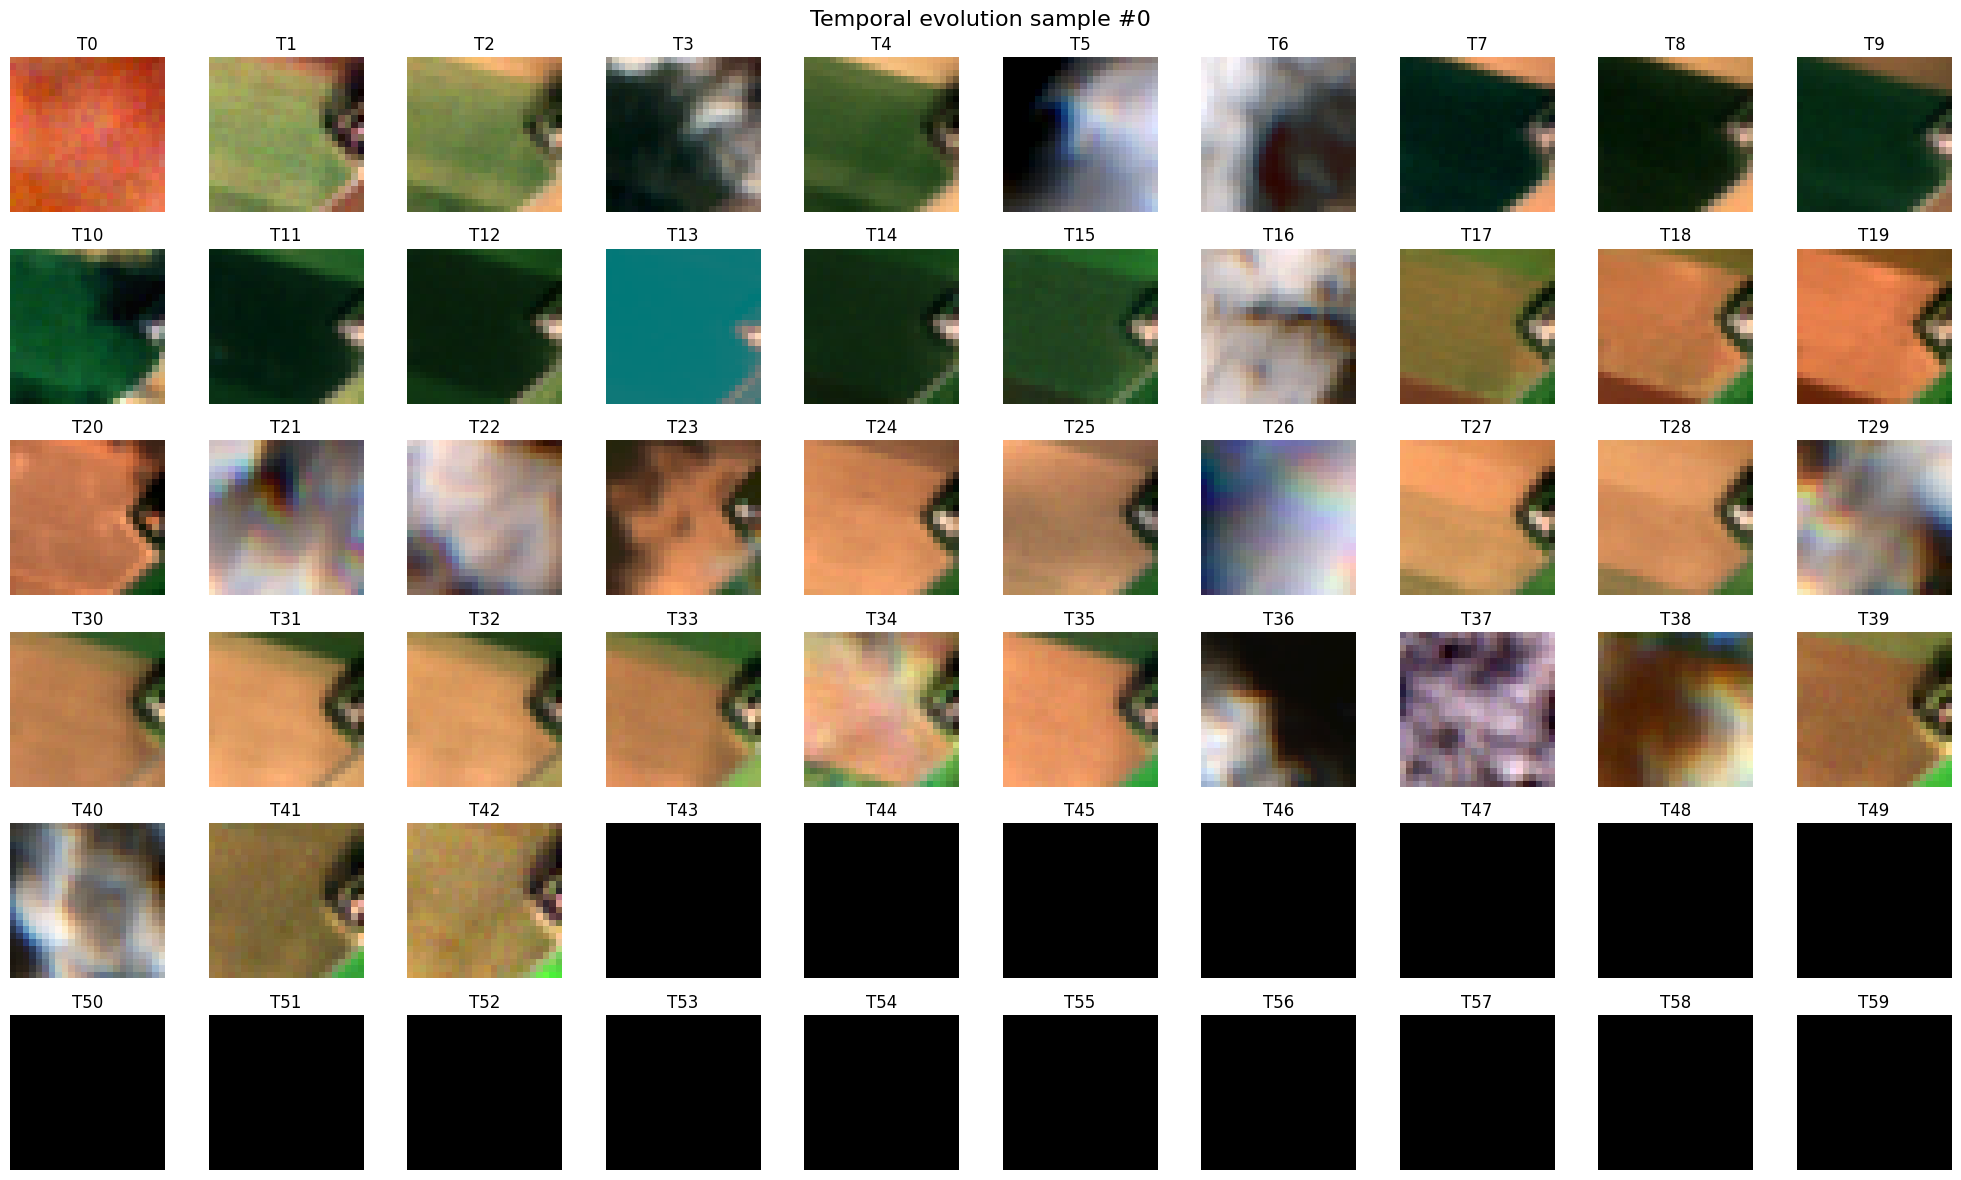

In [47]:
inputs = batch
#random_idx = random.randint(0, len(batch) - 1)
random_idx = 15
sample = batch[random_idx]['inputs'] 
rgb_indices = [2, 1, 0]
fig, axes = plt.subplots(6, 10, figsize=(20, 12))
fig.suptitle(f"Temporal evolution sample #{0}", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = sample[i] 
    rgb = img[:, :, rgb_indices]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-5)

    ax.imshow(rgb)
    ax.set_title(f'T{i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Análisis de Correlación de Canales

## Análisis de Distribución de Canales

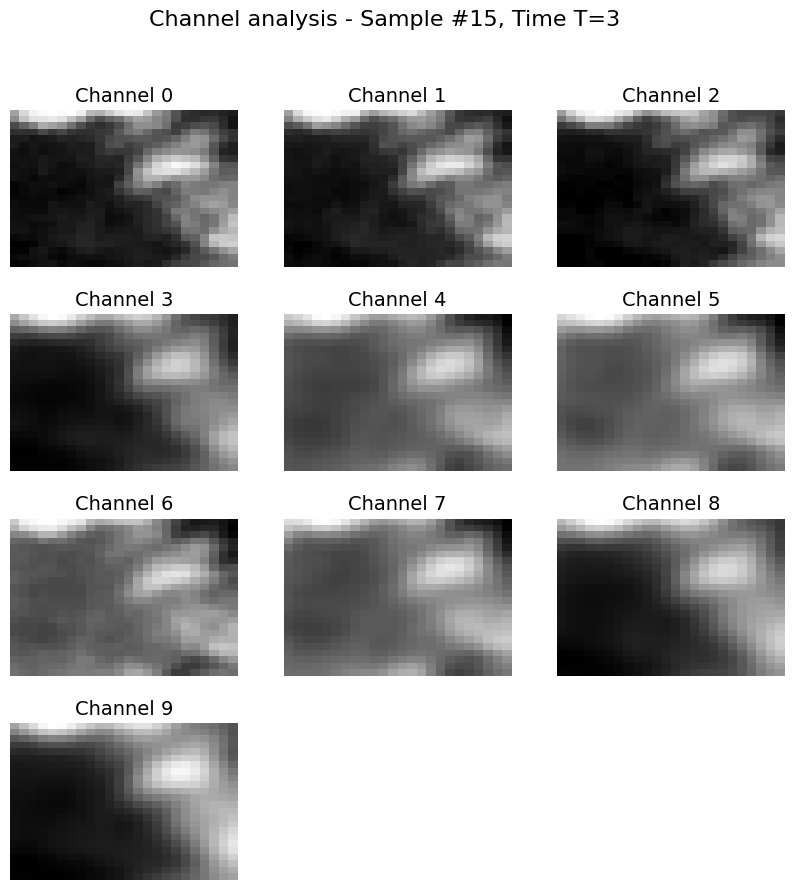

In [48]:
n_time, height, width, n_bands = sample.shape 
cols = 3
t = 3
rows = (n_bands + cols - 1) // cols 

fig, axs = plt.subplots(rows, cols, figsize=(10, 10)) 
for band in range(n_bands):
    ax = axs[band // cols, band % cols]  
    img = sample[t, :, :, band]  
    
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)

    ax.imshow(img, cmap='gray', aspect='auto')
    ax.set_title(f'Channel {band}', fontsize=14)
    ax.axis('off')

for i in range(n_bands, rows * cols):
    fig.delaxes(axs.flatten()[i])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

fig.suptitle(f"Channel analysis - Sample #{random_idx}, Time T={t}", fontsize=16)
plt.show()


**Banda 0 (Blue), 1 (Green), and 2 (Red)**: Estas imágenes muestran una diferencia tonal que puede representar variaciones por el tipo de superficie (por ejemplo, areas de agricultura vs. áreas de construcción). Sin embargo, no resaltan las áreas de vegetación tanto como otras bandas (tal como NIR).

**Banda 3, 4, 5, and 7 (Red Edge)**: Estas imágenes aparecen difumidadas en comparación a las bandas visibles, están diseñadas para analizar características específicas de la vegetación, en lugar de detalles visuales nítidos. En estas bandas, se aprecian diferencias sutiles en los campos agrícolas; estas bandas capturan la variabilidad en la estructura del follaje y la salud de la vegetación.

**Banda 6 (NIR)**: Esta imagen muestra un alto contraste en áreas con vegetación, ya que el infrarrojo cercano (IRC) se refleja con fuerza en las plantas sanas. Las áreas brillantes representan vegetación densa y sana, mientras que las zonas más oscuras podrían ser suelo, estructuras o vegetación menos densa. El contraste en esta banda permite una buena diferenciación de la vegetación de otras superficies. Se puede observar que las parcelas más oscuras en esta banda son aquellas que, en color verdadero, parecen suelo seco o con vegetación escasa, debido a su color apagado.

**Banda 8 y 9 (SWIR)**: Estas imágenes tienen un nivel de detalle menor, pero permiten inferir diferencias en el contenido de humedad. Las áreas más brillantes en las bandas SWIR pueden representar suelos secos o vegetación con menor contenido de agua, mientras que las áreas más oscuras pueden tener mayor contenido de agua o ser superficies sin vegetación. Estas bandas son útiles para detectar el estrés hídrico en la vegetación o la humedad del suelo. Se puede observar que las áreas opacas mencionadas anteriormente, que en la Banda 6 carecen de vegetación densa y sana, indican suelo o vegetación secos.

Para explorar más a fondo la relación entre las bandas, podemos crear una matriz de correlación.

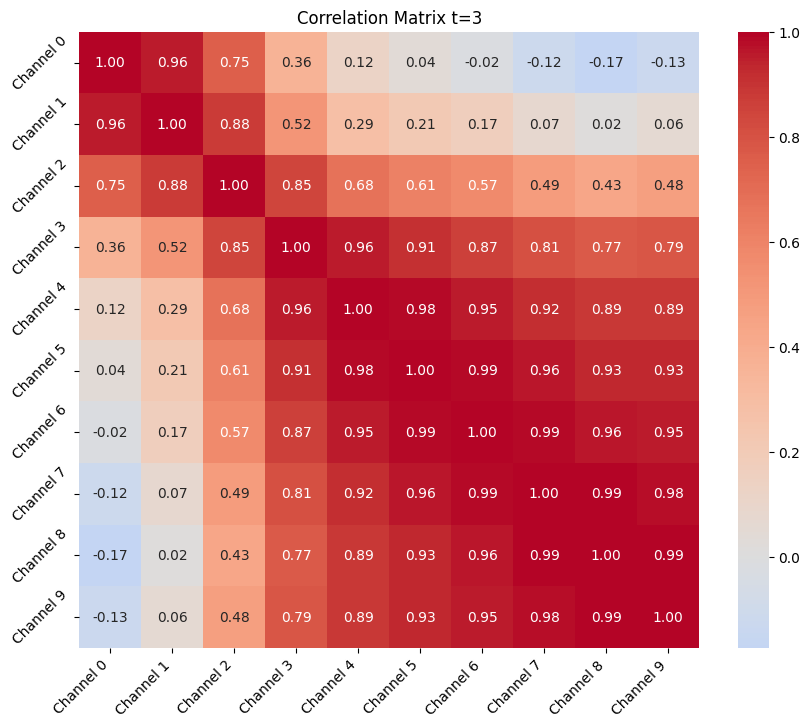

In [49]:
t = 3 
flattened_channels = [sample[t, channel].flatten() for channel in range(sample.shape[-1])]
correlation_matrix = np.corrcoef(flattened_channels)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f",
            xticklabels=[f'Channel {i}' for i in range(sample.shape[-1])],
            yticklabels=[f'Channel {i}' for i in range(sample.shape[-1])])

plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=45, ha='right')

plt.title(f'Correlation Matrix t={t}')
plt.show()


Como se muestra en las imágenes, se puede ver que las primeras cuatro bandas (0, 1, 2 y 3) tienen correlaciones muy bajas con las bandas 4, 5, 6 y 7. En particular, las bandas 0 y 2 tienen correlaciones notablemente bajas.

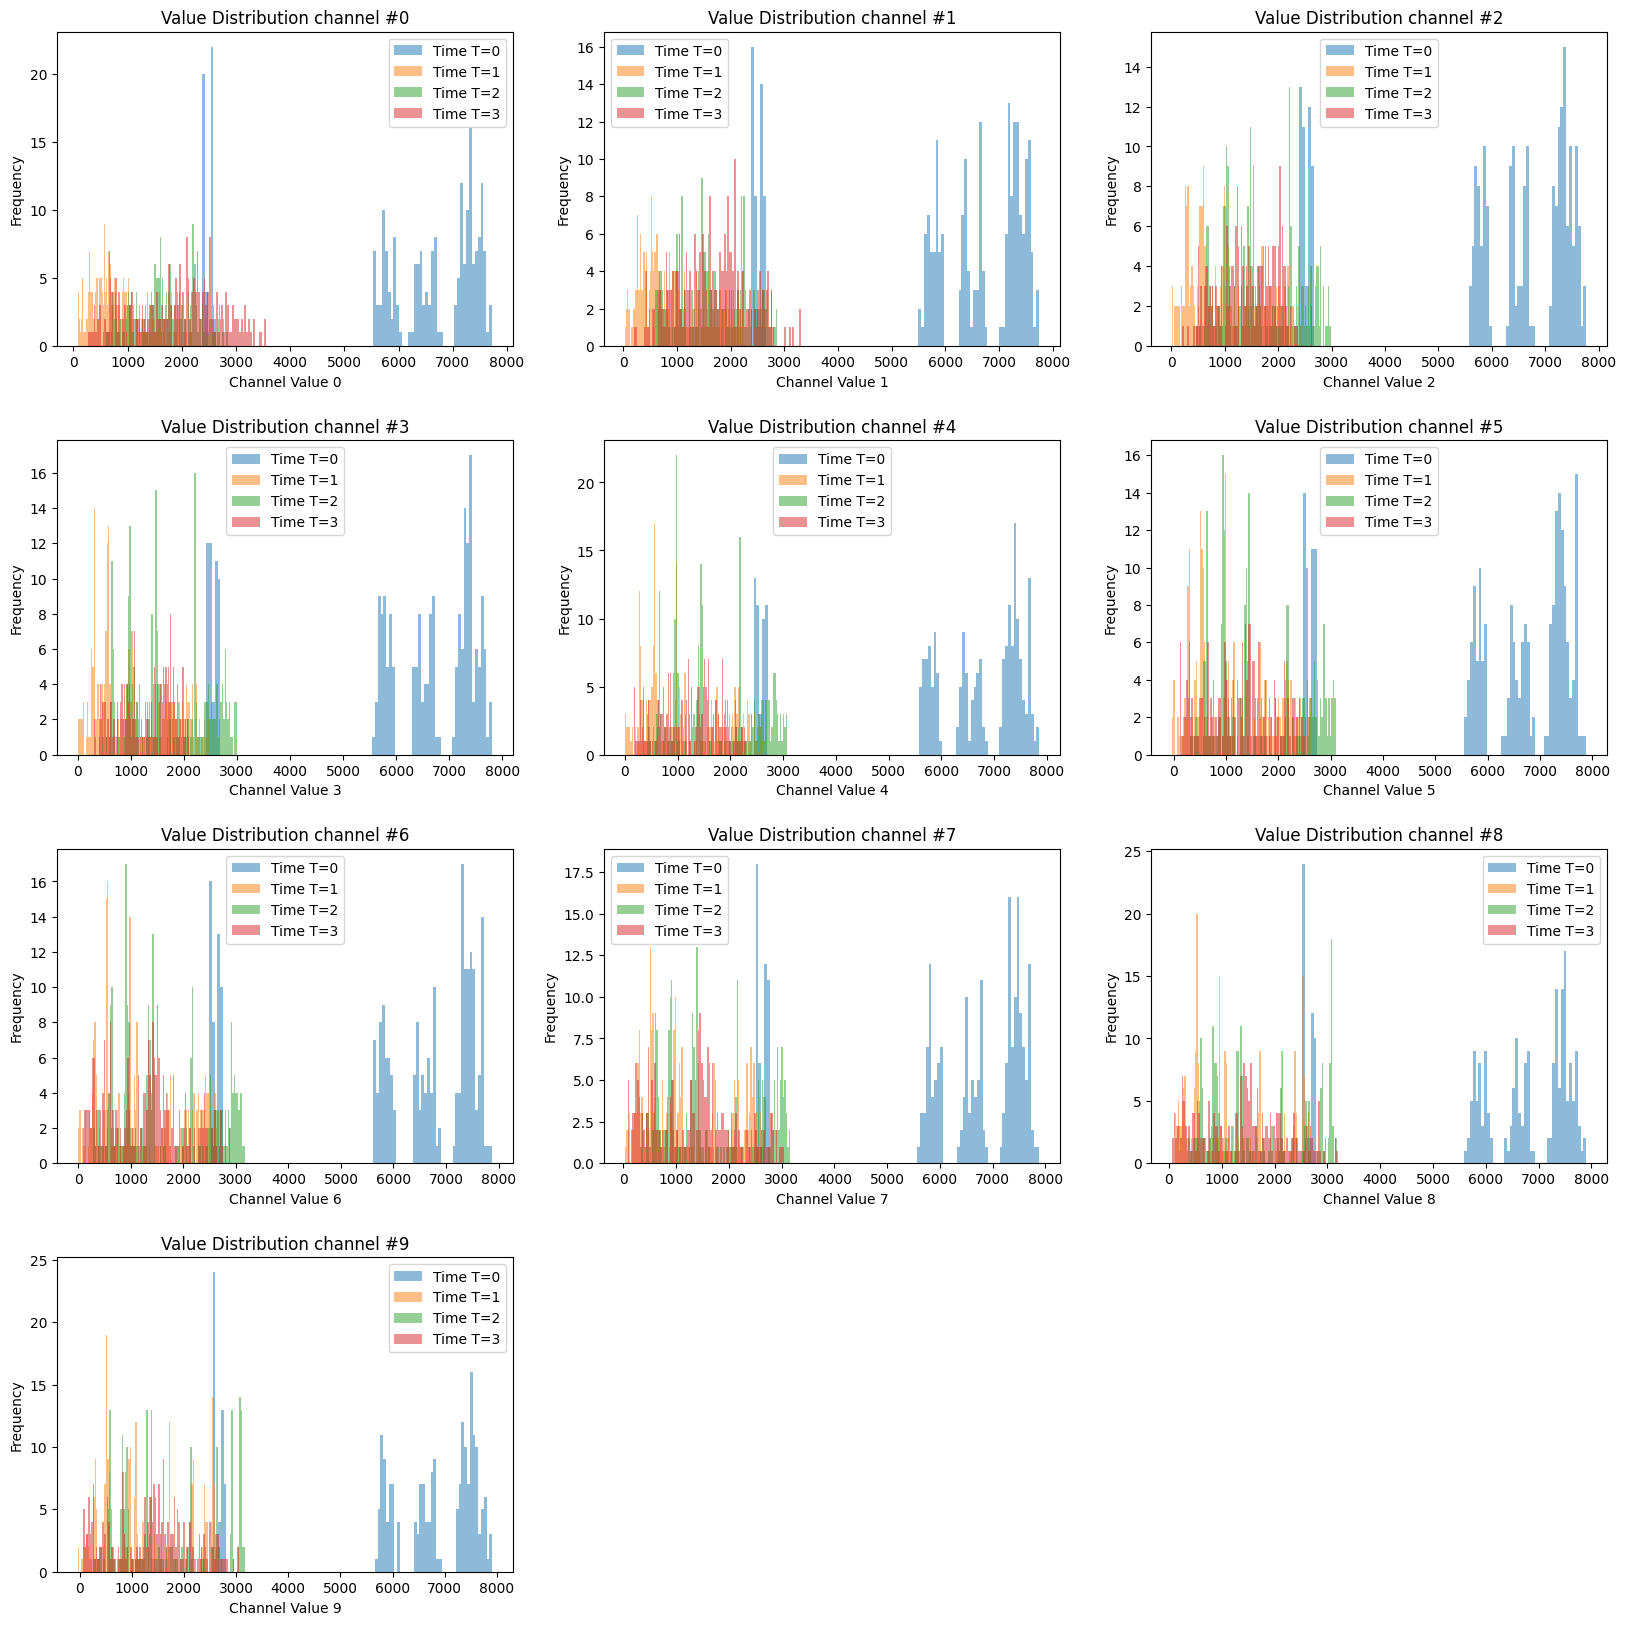

In [50]:
cols = 3
rows = (n_bands + cols - 1) // cols  
time_indices = [0, 1, 2, 3] 
fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 5))

for band in range(n_bands):
    ax = axs[band // cols, band % cols] 
    for t in time_indices:
        band_values = sample[t, band].flatten()
        ax.hist(band_values, bins=100, alpha=0.5, label=f'Time T={t}')
    ax.set_title(f'Value Distribution channel #{band}')
    ax.set_xlabel(f'Channel Value {band}')
    ax.set_ylabel('Frequency')
    ax.legend() 


for i in range(n_bands, rows * cols):
    fig.delaxes(axs.flatten()[i])

plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()


Estos histogramas ilustran la estructura espacial y la variabilidad dentro de cada canal, ofreciendo información sobre los tipos dominantes de cobertura terrestre o las características de la superficie capturadas en la imagen en cada punto de tiempo.

Los valores del eje x representan los niveles de intensidad de cada canal, correspondientes a la reflectancia medida a una longitud de onda específica (que varía según el canal). En otras palabras, estos valores indican la cantidad de luz reflejada por cada píxel en ese canal. Los histogramas muestran la frecuencia de cada valor de reflectancia en todos los píxeles de la imagen. Las frecuencias más altas indican que muchos píxeles comparten ese nivel de reflectancia, mientras que las frecuencias más bajas indican valores de intensidad más escasos.

El tiempo de adquisición más notable es el tiempo 0, que muestra valores de reflectancia consistentemente más altos en todos los canales. Esto probablemente se deba a la nubosidad en el momento de la captura, que aumenta el brillo general de la escena.

En los primeros cuatro canales (0, 1, 2 y 3), la reflectancia tiende a ser menor, lo que resulta en imágenes más oscuras. Esto se refleja en los histogramas, que están sesgados a la derecha, lo que indica una concentración de valores de menor intensidad. Si bien esta asimetría se observa en todos los canales, es más pronunciada en estos cuatro primeros.

En los tiempos 2 y 3, los histogramas tienden a mostrar múltiples picos definidos y distribuciones ligeramente más amplias (excluyendo el tiempo 0), lo que sugiere un rango más amplio de valores de reflectancia y una reflectancia general ligeramente mayor que otros pasos de tiempo. 

A partir de una interpretación específica del canal: dado que en los canales 8 y 9 las áreas más oscuras corresponden típicamente a regiones con mayor humedad del suelo, se puede inferir que las parcelas contienen suelos moderadamente húmedos para los tiempos analizados (excluyendo el tiempo 0), ya que los valores de reflectancia son bajos pero no en niveles extremos.

De manera similar, la mayoría de las parcelas parecen tener poca vegetación densa y saludable, como lo evidencian los valores consistentemente oscuros en los canales sensibles a la vegetación relevantes desde el momento 1 en adelante. 

### Etiquetas

In [6]:
with open("../datalake/colormap.txt", "r") as txt_file:
    colormap = txt_file.readlines()
colormap = [ast.literal_eval(line.strip().rstrip(',')) for line in colormap]

In [7]:
with open("../datalake/label_names_es.json", "r") as json_file:
    class_mapping = json.load(json_file)
class_mapping

{'0': 'Fondo',
 '1': 'Pradera',
 '2': 'Trigo blando de invierno',
 '3': 'MaÃ\xadz',
 '4': 'Cebada de invierno',
 '5': 'Colza de invierno',
 '6': 'Cebada de primavera',
 '7': 'Girasol',
 '8': 'Vid',
 '9': 'Remolacha',
 '10': 'Triticale de invierno',
 '11': 'Trigo duro de invierno',
 '12': 'Frutas, verduras, flores',
 '13': 'Papas',
 '14': 'Forraje leguminoso',
 '15': 'Soja',
 '16': 'Huerto',
 '17': 'Cereal mixto',
 '18': 'Sorgo',
 '19': 'Etiqueta vacÃ\xada'}

In [9]:
random_idx = 15
label = batch[random_idx]['labels'] 
label.shape

(3, 24, 24)

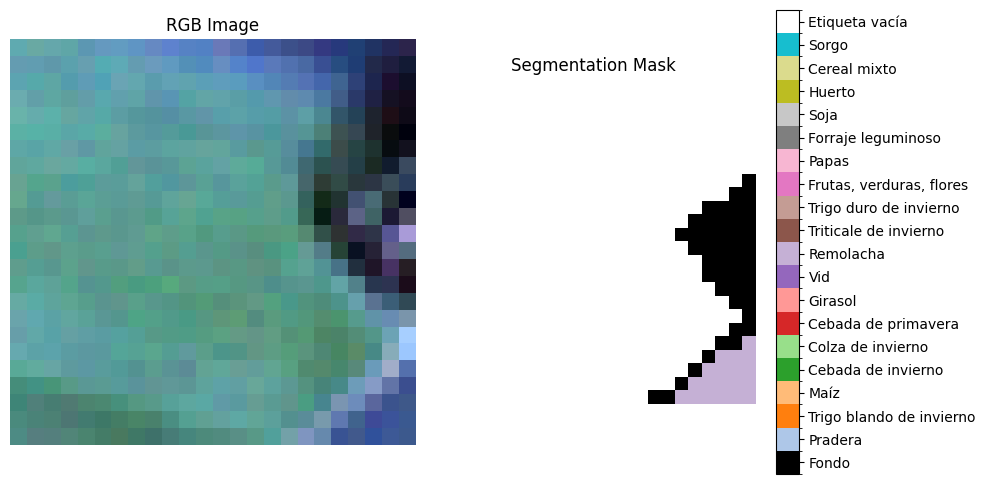

In [140]:
def plot_seg_mask(image, mask_array, colormap, class_labels=None):
    """
    Plots an RGB image alongside a segmentation mask with a custom colormap.
    
    Args:
        image (np.ndarray): Sample.
        mask_array (np.ndarray): 2D array representing the segmentation mask.
        colormap (list): List of RGB tuples for the colormap.
        class_labels (dict, optional): Dictionary mapping class indices to labels.
    """
    rgb_image = image[:, :, :3]
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
    
    custom_cmap = mcolors.ListedColormap(colormap)
    bounds = np.arange(len(colormap) + 1) - 0.5
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(rgb_image)
    axes[0].set_title("RGB Image")
    axes[0].axis("off")
    axes[0].set_aspect("equal")
    
    cax = axes[1].imshow(mask_array, cmap=custom_cmap, norm=norm)
    cbar = fig.colorbar(cax, ax=axes[1], ticks=np.arange(len(colormap)))
    cbar.set_ticks(np.arange(len(colormap)))
    cbar.set_ticklabels(list(class_labels.values()))
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Plot the segmentation mask
plot_seg_mask(sample[1], label[0], colormap, class_mapping)

In [141]:
label.shape

(3, 24, 24)

In [10]:
semantic = label[0]  
instances = label[1]
print("Unique values of semantic layer:", np.unique(semantic))

Unique values of semantic layer: [ 0  3 19]


## Gráfico de Barras de Clases

In [143]:
def get_area_per_class(seg_mask: np.array, label_names: dict, area_px_m2: int = 100) -> dict:
    """
    Get the area (in m2) of each class in the segmentation mask.
    Args:
        seg_mask (np.ndarray): Segmentation mask with class labels.
        classes (dict): Dictionary mapping class labels to their respective names.
        area_px_m2 (float): Area of one pixel in square meters.
        label_names (dict): Dictionary mapping class indices to labels.
    
    Returns:
        dict: Dictionary with class labels as keys and their respective areas in square meters.
    """
    classes, counts = np.unique(seg_mask, return_counts=True)
    if label_names is not None:
        areas_per_class = {
            label_names.get(str(int(crop_class))): int(count * area_px_m2)
            for crop_class, count in zip(classes, counts)
        }
        return areas_per_class

    return {
            str(int(crop_class)): int(count * area_px_m2)
            for crop_class, count in zip(classes, counts)
        }

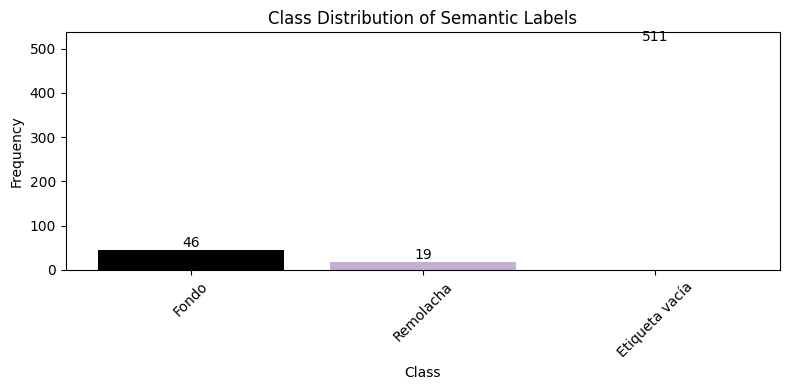

In [144]:
unique_classes, counts = np.unique(semantic, return_counts=True)
class_names = [class_mapping.get(str(cls), "Unknown") for cls in unique_classes]
colors = [colormap[cls] for cls in unique_classes]
plt.figure(figsize=(8, 4))
bars = plt.bar(class_names, counts, color=colors)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(count), 
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution of Semantic Labels")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Pie chart of Agricultural Distribution

Para esta muestra, es evidente que una gran parte del espacio capturado se identifica como desconocido, fondo y como capa vacía.

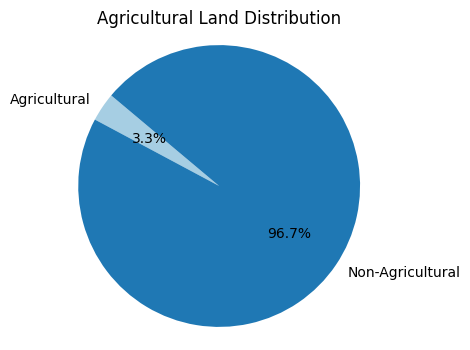

In [145]:
areas_agricolas = get_area_per_class(semantic, class_mapping, area_px_m2=100)
total_area = sum(list(areas_agricolas.values()))
agricultural_classes = [
    'Pradera',
    'Trigo blando de invierno',
    'Maíz',
    'Cebada de invierno',
    'Colza de invierno',
    'Cebada de primavera',
    'Girasol',
    'Vid',
    'Remolacha',
    'Triticale de invierno',
    'Trigo duro de invierno',
    'Frutas, verduras, flores',
    'Papas',
    'Forraje leguminoso',
    'Soja',
    'Huerto',
    'Cereal mixto',
    'Sorgo',
]
agricultural_area = sum([areas_agricolas.get(cls, 0) for cls in agricultural_classes])
non_agricultural_area = total_area - agricultural_area

# Calculate percentages
percentages = {'Agricultural': (agricultural_area / total_area) * 100,
               'Non-Agricultural': (non_agricultural_area / total_area) * 100}

labels = list(percentages.keys())
sizes = list(percentages.values())

# Create pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Agricultural Land Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


## Conclusiones

* Los datos analizados proviene de la fuente de datos PASTIS, que corresponde a imágenes satelitales en series de tiempo, de acuerdo al momento de la toma de datos, las imagenes tienen dimenciones de 24X24
* Cada registro de imágen tienen además 10 canales que muestran información adicional que ayudan a determinar el tipo de contenido registrado (vegetación, área agrícola, area de poca humedad, etc). Estas características serán determinantes en el proceso de entrenamiento, y debe ser considerada por la arquitectura del modelo ya que ayudará en el proceso de aprendizaje del modelo para determinar el tipo de cultivo registrado.
* Los datos consideran 19 clases, correspondientes a los tipos e cultivos registrados en cada imágen, ademas de otras zonas no agrícolas.
* Considerando que el objetivo del proyecto es la de obtener una respuesta en lenguaje natural de las áreas de cultivo registradas, asi como el tipo y cantidad correspondiente, la variable objetivo debe pasar por un proceso de ingeniería de características para dar la forma requerida a la varaible objetivo.
* El análisis exploratorio ayudó a determinar las variables importantes dentro de las imagenes, tal como los canales y las características relevantes en la determinación del tipo de cultivo, que proveen las imágenes satelitales, junto a la variabilidad registrada en el momento del registro.
* Si bien las imágenes no se ajustan a los pasos de un análisis exploratorio tradicional, se logro identificar características importantes que ayudarán al proceso de modelamiento y selección de la arquitectura, cumpliendo con el objetivo de un análisis exploratorio como tal.